<a href="https://colab.research.google.com/github/yaniv92648/OpenU_DL/blob/main/OpenU_DL_Maman_11_Introduction_Broadcast_AutoGrad.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

לינק להקלטה

https://drive.google.com/file/d/1T7oWU194Szid_QIJNfRn7rTu_yQgPWmY/view


In [ ]:
import torch
import matplotlib.pyplot as plt

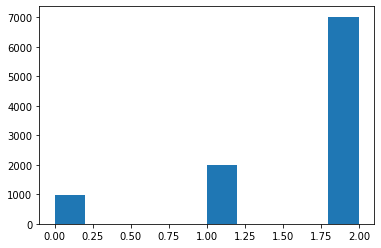

In [ ]:
# Question 1

def my_sampler(size, dist, requires_grad=False):
    # Sanity
    assert dist.sum() == 1, 'Sum of probabilities should equal to 1' 
    assert dist.all() > 0, 'Probabilities must be positive'
    # Algorithm
    U = torch.rand(size) # Generates a tensor with "size" ranom numbers from 0 to 1 (uniformly)
    I = torch.where(U < dist[0], torch.tensor(float(0)), U) # 1st condition
    I = torch.where(U >= 1-dist[-1], torch.tensor(float(dist.shape[0]-1)), I) # 2nd condition
    cumsum_dist = dist.cumsum(dim=0) # Accumulative sums of dist
    # 3rd condition
    for k in range(1, dist.numel() - 1):
      I = torch.where((U >= cumsum_dist[k-1]) & (U < cumsum_dist[k]), torch.tensor(float(k)), I)
    I.requires_grad = requires_grad # indicates if gradients need to be computed
    return I

plt.hist(my_sampler(size=10**4, dist=torch.tensor([0.1, 0.2, 0.7]), requires_grad=True).detach().numpy());

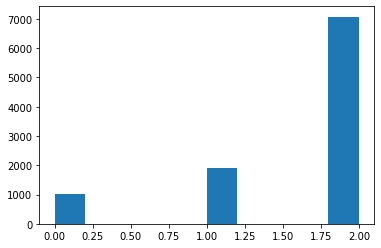

In [ ]:
# Question 1 - Bonus

def alias_sampler(size, dist, requires_grad=False):
  # Sanity
  assert dist.sum() == 1 # Sum of probabilities should equal to 1
  assert dist.all() > 0 # Probabilities must be positive
  # Creating probabilities table (U) & alias table (K)
  n = dist.shape[0]
  U = n * dist # How much "liquid" in every bucket
  # Each bucket is made of "liquids" that belongs to two buckets.
  # A key-value in K is the 1st & 2nd bucket, correspondingly
  K = torch.arange(n)
  while U[U < 1].any() and U[U > 1].any():
    i = (U > 1).nonzero()[0].item() # Overfull bucket index
    j = (U < 1).nonzero()[0].item() # Underfull bucket index
    K[j] = i # The i'th bucket fills the j's bucket
    U[i] -= 1 - U[j] # Remove the filled "liquids" from U[i]
    U[j] = 1 # Bucket U[j] is now full
  # Algorithm
  U = n * dist
  X = torch.rand(size) # Random number between 0 & 1 uniformly
  I = (n * X).to(torch.int64) # Random bucket choice
  Y = n * X - I # Random threshold in chosen bucket
  return torch.where(Y < U[I], I, K[I])

plt.hist(alias_sampler(size=10**4, dist=torch.tensor([0.1, 0.2, 0.7]), requires_grad=True).detach().numpy());

In [ ]:
# Question 2 - א

def broadcast_left_to_right(A, B):
  # Sanity
  if A.shape == B.shape:
    return A
  # First check if possible
  A_shape_rev, B_shape_rev = A.shape[::-1], B.shape[::-1]
  for i, dim_A in enumerate(A_shape_rev):
    dim_B = B_shape_rev[i]
    assert dim_A == dim_B or dim_A == 1, 'Broadcasting not possible'
  # Broascast
  for i, dim_A in enumerate(A.shape):
    dim_B = B.shape[i]
    if dim_A < dim_B:
      C = A.clone()
      while C.shape[i] < dim_B:
        C = torch.cat((C, A), dim=i)
  return C

In [ ]:
# Question 2 - א - Tests

# Sanity
a = torch.tensor([[1, 7], [2, 4]])
b = torch.tensor([[1, 2], [3, 4]])
print(f'Sanity test: {broadcast_left_to_right(a, b)}')

# Not possible
a = torch.tensor([[1, 7], [2, 4]])
b = torch.tensor([[1, 2], [3, 4], [2, 2]])
try:
  print(f'Not possible test: {broadcast_left_to_right(a, b)}')
except Exception as e: 
  print(f'Not possible test: {e}')

# Possible
a = torch.tensor([[1, 7]])
b = torch.tensor([[1, 2], [3, 4], [5, 6], [7, 8]])
print(f'Possible test: {broadcast_left_to_right(a, b)}')

Sanity test: tensor([[1, 7],
        [2, 4]])
Not possible test: Broadcasting not possible
Possible test: tensor([[1, 7],
        [1, 7],
        [1, 7],
        [1, 7]])


In [ ]:
# Question 2 - ב

def can_broadcast_together(A, B):
  # Sanity
  if A.shape == B.shape:
    return True, A.shape
  A_shape_rev, B_shape_rev = A.shape[::-1], B.shape[::-1]
  for i, dim_A in enumerate(A_shape_rev):
    dim_B = B_shape_rev[i]
    if dim_A != dim_B and dim_A != 1 and dim_B != 1:
      return False, None
  return True, torch.Size(torch.max(torch.tensor(A.shape), torch.tensor(B.shape)))

In [ ]:
# Question 2 - ב - Tests

# Sanity
a = torch.tensor([[1, 7, 9]])
b = torch.tensor([[2], [4]])
print(f'Sanity test: {can_broadcast_together(a, b)}')

# Possible
a = torch.tensor([[1, 7, 9]])
b = torch.tensor([[2], [4]])
print(f'Possible test: {can_broadcast_together(a, b)}')

# Not possible
a = torch.tensor([[1, 7, 9]])
b = torch.tensor([[2, 5], [4, 6]])
print(f'Not possible test: {can_broadcast_together(a, b)}')

Sanity test: (True, torch.Size([2, 3]))
Possible test: (True, torch.Size([2, 3]))
Not possible test: (False, None)


In [ ]:
# Question 2 - ג

def broadcast_together(A, B):
  # Sanity
  if A.shape == B.shape:
    return A, B
  can_broadcast, size = can_broadcast_together(A, B)
  if not can_broadcast:
    return 'Cannot Broadcast!'
  # Broascast
  zeros = torch.zeros(size)
  A_broadcasted = broadcast_left_to_right(A, zeros)
  B_broadcasted = broadcast_left_to_right(B, zeros)
  return A_broadcasted, B_broadcasted

In [ ]:
# Question 2 - ד

a = torch.tensor([[1, 7]])
b = torch.tensor([[1, 2], [3, 4], [5, 6], [7, 8]])
print(f'1. {torch.all(a.expand_as(b) == broadcast_left_to_right(a, b))}')

a = torch.tensor([[1, 7, 9]])
b = torch.tensor([[2, 5], [4, 6]])
print(f'2. {broadcast_together(a, b)}')
try:
  torch.broadcast_tensors(a, b)
except Exception as e: 
  print(e)

a = torch.tensor([[1, 7, 9]])
b = torch.tensor([[2], [4]])
br_to_a_b, br_to_b_a = broadcast_together(a, b)
br_te_a_b, br_te_b_a = torch.broadcast_tensors(a, b)
print(f'3. {torch.all(br_to_a_b == br_te_a_b)}')
print(f'4. {torch.all(br_to_b_a == br_te_b_a)}')

1. True
2. Cannot Broadcast!
The size of tensor a (3) must match the size of tensor b (2) at non-singleton dimension 1
3. True
4. True


In [ ]:
# Question 3

from collections import defaultdict


class MyScalar:

  # gradient_2 & parent_2 is for the bonus
  def __init__(self, value=None, gradient_1=1, gradient_2=1, parent_1=None, parent_2=None):
    self.value = value if (type(value) == torch.Tensor) else torch.tensor(value)
    self.gradient_1 = gradient_1 if (type(gradient_1) == torch.Tensor) else torch.tensor(gradient_1)
    self.gradient_2 = gradient_2 if (type(gradient_2) == torch.Tensor) else torch.tensor(gradient_2)
    self.parent_1 = parent_1
    self.parent_2 = parent_2
    self.ID = str(hash(self))


gradient_dict = defaultdict(lambda:0)


# Regular + Bonus
def get_gradient(my_scalar):
  if my_scalar.ID not in gradient_dict:
    gradient_dict[my_scalar.ID] = 1
  if my_scalar.parent_1 is not None:
    gradient_dict[my_scalar.parent_1.ID] += gradient_dict[my_scalar.ID] * my_scalar.gradient_1.item()
    get_gradient(my_scalar.parent_1)
  if my_scalar.parent_2 is not None:
    gradient_dict[my_scalar.parent_2.ID] += gradient_dict[my_scalar.ID] * my_scalar.gradient_2.item()
    get_gradient(my_scalar.parent_2)
  return gradient_dict



class MathLibrary:

  @staticmethod
  def exp(my_scalar):
    return MyScalar(value=torch.exp(my_scalar.value), 
                    gradient_1=torch.exp(my_scalar.value), 
                    parent_1=my_scalar)
  
  @staticmethod
  def ln(my_scalar):
    return MyScalar(value=torch.log(my_scalar.value),
                    gradient_1=1/my_scalar.value, 
                    parent_1=my_scalar)

  @staticmethod
  def sin(my_scalar):
    return MyScalar(value=torch.sin(my_scalar.value),
                    gradient_1=torch.cos(my_scalar.value),
                    parent_1=my_scalar)
    
  @staticmethod
  def cos(my_scalar):
    return MyScalar(value=torch.cos(my_scalar.value),
                    gradient_1=-torch.sin(my_scalar.value),
                    parent=my_scalar)
  
  @staticmethod
  def power(my_scalar, exponent):
    return MyScalar(value=torch.pow(my_scalar.value, exponent),
                    gradient_1=exponent*torch.pow(my_scalar.value, exponent-1),
                    parent_1=my_scalar)
  
  @staticmethod
  def addition(my_scalar, addition_value):
    return MyScalar(value=my_scalar.value+addition_value,
                    gradient_1=1, 
                    parent_1=my_scalar)
    
  @staticmethod
  def product(my_scalar, product_value):
    return MyScalar(value=my_scalar.value*product_value,
                    gradient_1=product_value, 
                    parent_1=my_scalar)
  
  # Bonus
  @staticmethod
  def product_scalars(my_scalar_1, my_scalar_2):
    return MyScalar(value=my_scalar_1.value*my_scalar_2.value,
                    gradient_1=my_scalar_2.value, 
                    gradient_2=my_scalar_1.value, 
                    parent_1=my_scalar_1,
                    parent_2=my_scalar_2)

  # Bonus
  @staticmethod
  def division_scalars(my_scalar_1, my_scalar_2):
    return MyScalar(value=my_scalar_1.value/my_scalar_2.value,
                    gradient_1=1/my_scalar_2.value, 
                    gradient_2=-my_scalar_1.value*pow(my_scalar_2.value, -2),
                    parent_1=my_scalar_1,
                    parent_2=my_scalar_2)
    
  # Bonus
  @staticmethod
  def addition_scalars(my_scalar_1, my_scalar_2):
    return MyScalar(value=my_scalar_1.value+my_scalar_2.value,
                    gradient_1=1,
                    gradient_2=1,
                    parent_1=my_scalar_1,
                    parent_2=my_scalar_2)

In [ ]:
# Tests for Q3

a_user = MyScalar(value=2) # a_user == 2
a_user.ID = 'a_user'
b_user = MathLibrary.power(a_user, 2) # b_user == 4
b_user.ID = 'b_user'
c_user = MathLibrary.exp(b_user) # c_user == ~54.59
c_user.ID = 'c_user'

a_cp = torch.tensor(2., requires_grad=True) # a_cp == 2
b_cp = torch.pow(a_cp, 2) # b_cp == 4
b_cp.retain_grad() # Enables this Tensor to have their grad populated during backward()
c_cp = torch.exp(b_cp) # c_cp == ~54.59
c_cp.retain_grad() # Enables this Tensor to have their grad populated during backward()
c_cp.backward() # Computes the gradient of current tensor w.r.t. graph leaves.

gradient_dict.clear()

print(f'a_user = {a_user.value}, b_user = {b_user.value}, c_user = {c_user.value}')
print(f'a_cp = {a_cp.item()}, b_cp = {b_cp.item()}, c_cp = {c_cp.item()}\n')
print(dict(get_gradient(c_user)))
print({'c_cp': c_cp.grad.item(), 'b_cp': b_cp.grad.item(), 'a_cp': a_cp.grad.item()})

a_user = 2, b_user = 4, c_user = 54.598148345947266
a_cp = 2.0, b_cp = 4.0, c_cp = 54.598148345947266

{'c_user': 1, 'b_user': 54.598148345947266, 'a_user': 218.39259338378906}
{'c_cp': 1.0, 'b_cp': 54.598148345947266, 'a_cp': 218.39259338378906}


In [ ]:
# Tests for Q3 - Bonus

a_user = MyScalar(value=2) # a_user == 2
a_user.ID = 'a_user'
b_user = MathLibrary.power(a_user, 4) # b_user == 16
b_user.ID = 'b_user'
c_user = MathLibrary.exp(a_user) # c_user == ~7.38
c_user.ID = 'c_user'
d_user = MathLibrary.product_scalars(b_user, c_user) # d_user == ~118.22
d_user.ID = 'd_user'

a_cp = torch.tensor(2., requires_grad=True) # a_cp == 2
b_cp = torch.pow(a_cp, 4) # b_cp == 16
b_cp.retain_grad() # Enables this Tensor to have their grad populated during backward()
c_cp = torch.exp(a_cp) # c_cp == ~7.38
c_cp.retain_grad() # Enables this Tensor to have their grad populated during backward()
d_cp = b_cp * c_cp # d_cp == ~118.22
d_cp.retain_grad() # Enables this Tensor to have their grad populated during backward()
d_cp.backward() # Computes the gradient of current tensor w.r.t. graph leaves.

gradient_dict.clear()

print(f'a_user = {a_user.value}, b_user = {b_user.value}, c_user = {c_user.value}, d_user = {d_user.value}')
print(f'a_cp = {a_cp.item()}, b_cp = {b_cp.item()}, c_cp = {c_cp.item()},  d_cp = {d_cp.item()}\n')
print(dict(get_gradient(d_user)))
print({'d_cp': d_cp.grad.item(), 'c_cp': c_cp.grad.item(), 'b_cp': b_cp.grad.item(), 'a_cp': a_cp.grad.item()})

a_user = 2, b_user = 16, c_user = 7.389056205749512, d_user = 118.22489929199219
a_cp = 2.0, b_cp = 16.0, c_cp = 7.389056205749512,  d_cp = 118.22489929199219

{'d_user': 1, 'b_user': 7.389056205749512, 'a_user': 354.67469787597656, 'c_user': 16}
{'d_cp': 1.0, 'c_cp': 16.0, 'b_cp': 7.389056205749512, 'a_cp': 354.6746826171875}
